## Make N3 and N4 in Mei-Yin-Chou

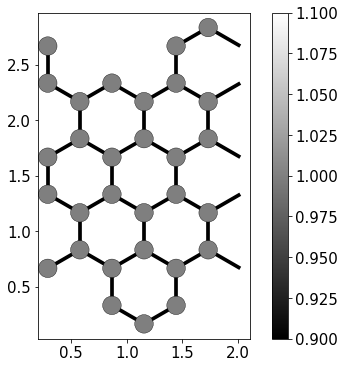

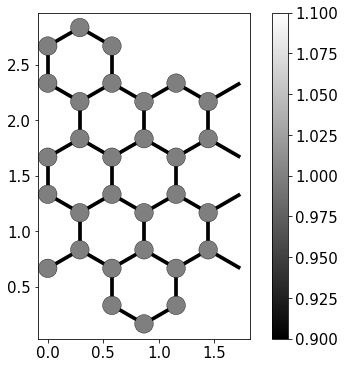

In [6]:
%run notebook_setup.ipy
from helper import *
N=12
L=6
Z7 = make_cove_edged_graphene(N=N,L=L)
cove_ribbon = finite_to_1D(Z7,get_length(L),trans_sym_direction='x')

sites = list(Z7.sites())
pos = [site.pos for site in sites]
pos = translate(pos,0,N,L)
cove_lattice = kwant.lattice.general([[get_length(L),0],[0,get_width(N)]],pos)
cove_ribbon = kwant.Builder(kwant.TranslationalSymmetry(cove_lattice.prim_vecs[0]))
cove_ribbon[cove_lattice.shape((lambda pos: 0 <= pos[1] < get_width(N)),(0,0))]=1
cove_ribbon[cove_lattice.neighbors()] = -1
fig = kwant.plot(cove_ribbon,site_color=family_color,site_lw=0.01);

pos[:,0] = get_length(L) -1*pos[:,0]
pos = translate(pos,np.sqrt(3)/6,N,L)

N4_lattice = kwant.lattice.general([[get_length(L),0],[0,get_width(N)]],pos)
N4 = kwant.Builder(kwant.TranslationalSymmetry(N4_lattice.prim_vecs[0]))
N4[N4_lattice.shape((lambda pos: 0 <= pos[1] < get_width(N)),(0,0))]=1
N4[N4_lattice.neighbors()] = -1
fig = kwant.plot(N4,site_color=family_color,site_lw=0.01);

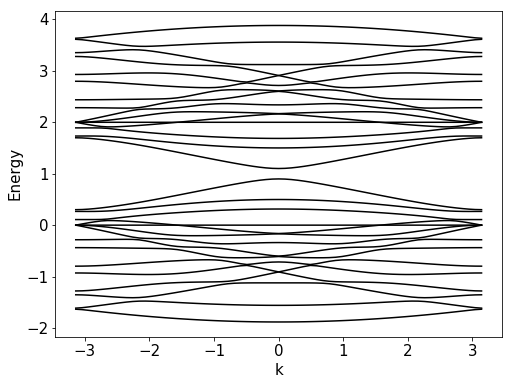


+----------------------------------------------------------------------+
|        ================                                              |
|        LINE CALCULATION                                              |
|        ================                                              |
|        starting at 2019-06-26 13:54:41,380                           |
|        running Z2Pack version 2.1.1                                  |
|                                                                      |
|        init_result: None                                             |
|        iterator:    range(8, 27, 2)                                  |
|        line:        <function <lambda> at 0x11527c840>               |
|        load:        False                                            |
|        load_quiet:  True                                             |
|        pos_tol:     0.01                                             |
|        save_file:   None                        

In [7]:
wcc_N={}
import z2pack
from Z2_compute import zak_bands as zak_bands_z2
cove_ribbon = cove_ribbon.finalized()
kwant.plotter.bands(cove_ribbon)
act_pos = np.array([cove_ribbon.pos(i) for i in range(len(sites))])
a1,a2 = [cove_lattice.prim_vecs[0][0],get_width(N=N)]
red_pos = np.zeros(np.shape(act_pos))
red_pos[:,0] = act_pos[:,0]/a1
red_pos[:,1] = act_pos[:,1]/a2


ham_k=zak_bands_z2(cove_ribbon,momenta=1001,dim=2)
z2_system = z2pack.hm.System(ham_k,dim=2,#pos=red_pos,
                                     convention=2)
result = z2pack.line.run(system=z2_system, 
                            line=lambda t1: [t1,0])#,#,n/(N+1)])#,
                            #pos_tol=1e-3,iterator=range(200,500,2));

print("Polarization:",result.pol)

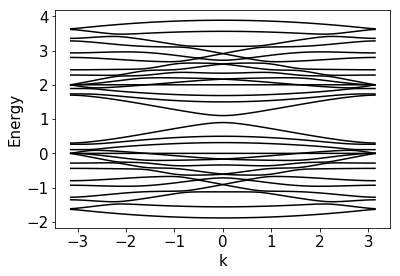


+----------------------------------------------------------------------+
|        ================                                              |
|        LINE CALCULATION                                              |
|        ================                                              |
|        starting at 2019-06-26 13:54:34,277                           |
|        running Z2Pack version 2.1.1                                  |
|                                                                      |
|        init_result: None                                             |
|        iterator:    range(8, 27, 2)                                  |
|        line:        <function <lambda> at 0x1150f0f28>               |
|        load:        False                                            |
|        load_quiet:  True                                             |
|        pos_tol:     0.01                                             |
|        save_file:   None                        

In [3]:
wcc_N={}
import z2pack
from Z2_compute import zak_bands as zak_bands_z2
#cove_ribbon = cove_ribbon.finalized()
N4 = N4.finalized()
kwant.plotter.bands(N4)
act_pos = np.array([N4.pos(i) for i in range(len(sites))])
a1,a2 = [N4_lattice.prim_vecs[0][0],get_width(N=N)]
red_pos = np.zeros(np.shape(act_pos))
red_pos[:,0] = act_pos[:,0]/a1
red_pos[:,1] = act_pos[:,1]/a2


ham_k=zak_bands_z2(N4,momenta=1001,dim=2)
z2_system = z2pack.hm.System(ham_k,dim=2,#pos=red_pos,
                                     convention=2)
result = z2pack.line.run(system=z2_system, 
                            line=lambda t1: [t1,0])#,#,n/(N+1)])#,
                            #pos_tol=1e-3,iterator=range(200,500,2));

print("Polarization:",result.pol)

In [4]:
def make_junction(syst1,syst2,lx1,lx2,ly,xoff=0,yoff=0):
    lx = lx1 + lx2
    nx = 6
    nx1 = nx 
    nx2 = nx
    pos_all0 = []
    #pos1 =  [[site.pos[0],site.pos[1]] for site in syst1.sites()]
    #pos2 =  [[site.pos[0],site.pos[1]] for site in syst2.sites()]
    for i in range(nx1):
        pos1 =  [[site.pos[0] + i*lx1,site.pos[1]] for site in syst1.sites()]
        pos_all0 += pos1
    for i in range(nx2): 
        pos2 =  [[site.pos[0] + nx1*lx1 + i*lx2+xoff,site.pos[1]+yoff] for site in syst2.sites()]
        pos_all0 += pos2
    pos_all = pos_all0
    #pos_all = []
    #for item in pos_all0:
    #    if item not in pos_all: 
    #        pos_all.append(item)
        #print(item)

    min_y = np.min(np.array(pos_all)[:,1])
    lat = kwant.lattice.general([[nx*lx,0],[0,2*ly]],pos_all,norbs=1)
    #syst = kwant.Builder(kwant.TranslationalSymmetry([lx,0]))
    syst = kwant.Builder()
    syst[lat.shape((lambda pos: 0< pos[0]< nx*lx+xoff and min_y + yoff<=pos[1]<ly+yoff),(0,0))] = 0 
    syst[lat.neighbors()] = -1 
    print(len(pos1),len(pos2),len(pos_all))
    return syst 

def plot_wf(syst,i_start,i_end,ham):
    """Plot the wave function mapping on system with Hamiltonian 
    "ham" in a PyWidget starting from band index i_start and 
    ending at i_end"""
    eig_val,eig_vec = la.eigh(ham)
    def plot_band(i=0): 
        print("Plotting wave function with index",i)
        print("Energy of the corresponding mode",eig_val[i], "x t")
        fig = kwant.plotter.map(syst,abs(eig_vec[:,i])**2,oversampling=3,fig_size=(16,10))
        
        #fig.savefig('figures/%s.jpg'%i,dpi=400,quality=100,transparent=True)
    
    interact(plot_band,i=(i_start,i_end))

In [11]:
def check_junction(syst1,syst2,lx1,lx2,ly=14,xoff=0,yoff=0):
    syst = make_junction(syst1,syst2,lx1,lx2,ly,xoff,yoff)
    syst.eradicate_dangling()
    kwant.plot(syst,site_color='black');
    
    nbands = len(syst.sites())
    n1 = int(nbands/2 -5)
    n2 = int(nbands/2 +5)
    print('Number of bands in junction is {}'.format(nbands))
    
    syst = syst.finalized()
    ham = syst.hamiltonian_submatrix() 
    fig = plot_wf(syst,n1,n2,ham)

30 30 360


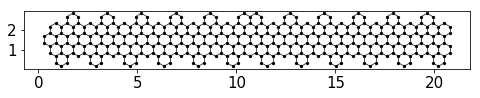

Number of bands in junction is 357


interactive(children=(IntSlider(value=173, description='i', max=183, min=173), Output()), _dom_classes=('widge…

In [7]:
check_junction(cove_ribbon,N4,lx1=get_length(6),lx2=get_length(6),ly=16,xoff=np.sqrt(3)/6)

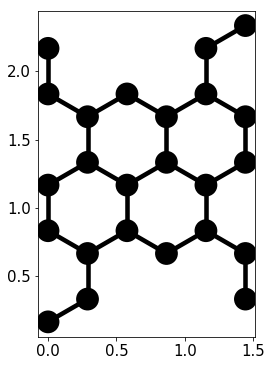

In [12]:
temp = make_zigzag_ribbon(N=10,L=6)
sites = [site for site in temp.sites()]
for site in sites: 
    if 0 < site.pos[0] <1 and site.pos[1] > 2: 
        del temp[site]
for site in sites: 
    if 0.5 < site.pos[0] < 1.25 and site.pos[1] < 0.5: 
        del temp[site]
kwant.plot(temp);
S1 = temp

24 30 324


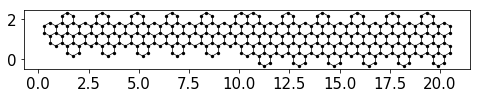

Number of bands in junction is 317


interactive(children=(IntSlider(value=153, description='i', max=163, min=153), Output()), _dom_classes=('widge…

In [10]:
check_junction(S1,N4,lx1=get_length(6),lx2=get_length(6),ly=16,xoff=0,yoff=-0.5)

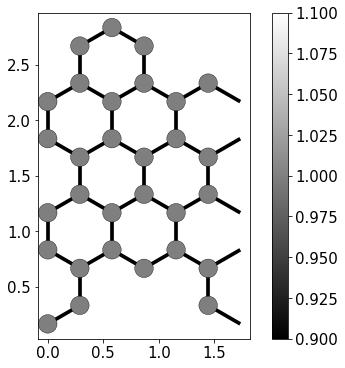

In [16]:
sites = list(Z7.sites())
pos = [site.pos for site in sites]
pos = translate(pos,get_length(2),N,L)
N3d = kwant.lattice.general([[get_length(L),0],[0,get_width(N)]],pos)
N3d_ribbon = kwant.Builder(kwant.TranslationalSymmetry(N3d.prim_vecs[0]))
N3d_ribbon[N3d.shape((lambda pos: 0 <= pos[1] < get_width(N)),(0,0))]=1
N3d_ribbon[N3d.neighbors()] = -1
fig = kwant.plot(N3d_ribbon,site_color=family_color,site_lw=0.01);

24 30 324


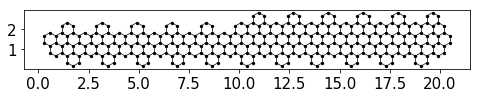

Number of bands in junction is 314


interactive(children=(IntSlider(value=152, description='i', max=162, min=152), Output()), _dom_classes=('widge…

In [17]:
check_junction(S1,N3d_ribbon,lx1=get_length(6),lx2=get_length(6),ly=16,xoff=0,yoff=0)

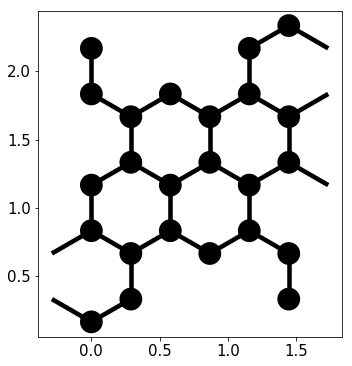

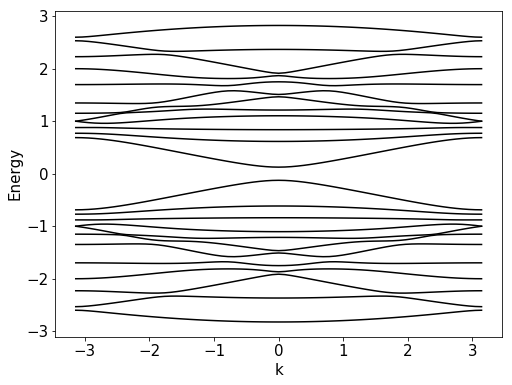


+----------------------------------------------------------------------+
|        ================                                              |
|        LINE CALCULATION                                              |
|        ================                                              |
|        starting at 2019-06-20 19:01:49,482                           |
|        running Z2Pack version 2.1.1                                  |
|                                                                      |
|        init_result: None                                             |
|        iterator:    range(8, 27, 2)                                  |
|        line:        <function <lambda> at 0x125af79d8>               |
|        load:        False                                            |
|        load_quiet:  True                                             |
|        pos_tol:     0.01                                             |
|        save_file:   None                        

In [13]:
wcc_N={}
import z2pack
from Z2_compute import zak_bands as zak_bands_z2
#cove_ribbon = cove_ribbon.finalized()
S1= finite_to_1D(S1,get_length(6),trans_sym_direction='x')
kwant.plot(S1)
pos = [ site.pos for  site in S1.sites()]
nsites = len(pos)
S1 = S1.finalized()
kwant.plotter.bands(S1)
S1_lattice = kwant.lattice.general([[get_length(L),0],[0,get_width(12)]],pos)
act_pos = np.array([S1.pos(i) for i in range(nsites)])
a1,a2 = [S1_lattice.prim_vecs[0][0],get_width(N=N)]
red_pos = np.zeros(np.shape(act_pos))
red_pos[:,0] = act_pos[:,0]/a1
red_pos[:,1] = act_pos[:,1]/a2


ham_k=zak_bands_z2(S1,momenta=1001,dim=2)
z2_system = z2pack.hm.System(ham_k,dim=2,#pos=red_pos,
                                     convention=2)
result = z2pack.line.run(system=z2_system, 
                            line=lambda t1: [t1,0])#,#,n/(N+1)])#,
                            #pos_tol=1e-3,iterator=range(200,500,2));

print("Polarization:",result.pol)

In [8]:
def get_pol_custom(syst):
    pos = [ site.pos for  site in syst.sites()]
    nsites = len(pos)
    syst = syst.finalized()
    kwant.plotter.bands(syst)
    lattice = kwant.lattice.general([[get_length(L),0],[0,get_width(16)]],pos)
    act_pos = np.array([syst.pos(i) for i in range(nsites)])
    a1,a2 = [lattice.prim_vecs[0][0],get_width(N=N)]
    red_pos = np.zeros(np.shape(act_pos))
    red_pos[:,0] = act_pos[:,0]/a1
    red_pos[:,1] = act_pos[:,1]/a2


    ham_k=zak_bands_z2(syst,momenta=1001,dim=2)
    z2_system = z2pack.hm.System(ham_k,dim=2,#pos=red_pos,
                                     convention=1)
    result = z2pack.line.run(system=z2_system, 
                            line=lambda t1: [t1,0])#,#,n/(N+1)])#,
                            #pos_tol=1e-3,iterator=range(200,500,2));

    print("Polarization:",result.pol)

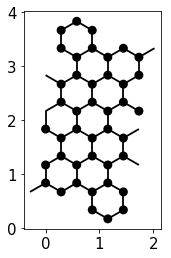

In [7]:
temp = make_zigzag_ribbon(N=16,L=7)
sites = [site for site in temp.sites()]
for site in sites: 
    if site.pos[0] > 1.5 and site.pos[1] < 2.0: 
        del temp[site]
    if site.pos[0] < 0.1 and site.pos[1] > 2.0: 
        del temp[site]
    if 0.9<=site.pos[0] and site.pos[1] > 3.5: 
        del temp[site]
    if 0<=site.pos[0] < 0.8 and site.pos[1] < 0.5: 
        del temp[site]
#for site in sites: 
#    if 0 <= site.pos[0] < 0.8 and site.pos[1] < 0.5: 
#        del temp[site]
S2 = temp
S2 = finite_to_1D(S2,get_length(6),trans_sym_direction='x')
kwant.plot(S2);

In [ ]:
get_pol_custom(S2)

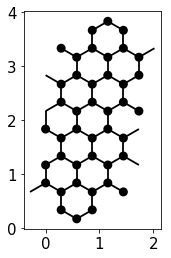

In [4]:
temp = make_zigzag_ribbon(N=16,L=7)
sites = [site for site in temp.sites()]

for site in sites: 
    if site.pos[0] < 0.6 and site.pos[1] > 3.5: 
        del temp[site]
    if site.pos[0] > 1.5 and site.pos[1] < 2.0: 
        del temp[site]
    if site.pos[0] < 0.1 and site.pos[1] > 2.0: 
        try:
            del temp[site]
        except: 
            continue
    if 1.5< site.pos[0] and site.pos[1] > 3.5: 
        del temp[site]
    if 0<=site.pos[0] < 0.1 and site.pos[1] < 0.5: 
        del temp[site]
    if site.pos[0] > 1 and site.pos[1] < 0.5: 
        try:
            del temp[site]
        except: 
            continue
#for site in sites: 
#    if 0 <= site.pos[0] < 0.8 and site.pos[1] < 0.5: 
#        del temp[site]
S3 = temp
S3 = finite_to_1D(S3,get_length(6),trans_sym_direction='x')
kwant.plot(S3);
#kwant.plot(temp);

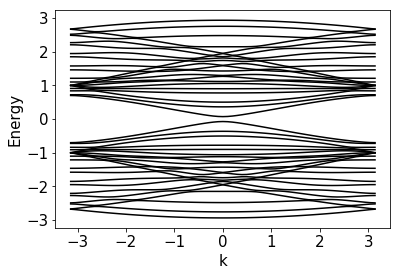


+----------------------------------------------------------------------+
|================                                                      |
|LINE CALCULATION                                                      |
|================                                                      |
|starting at 2019-06-20 19:02:40,819                                   |
|running Z2Pack version 2.1.1                                          |
|                                                                      |
|init_result: None                                                     |
|iterator:    range(8, 27, 2)                                          |
|line:        <function get_pol_custom.<<...>>.<lambda> at 0x1168e1a60>|
|load:        False                                                    |
|load_quiet:  True                                                     |
|pos_tol:     0.01                                                     |
|save_file:   None                                

In [5]:
get_pol_custom(S3)

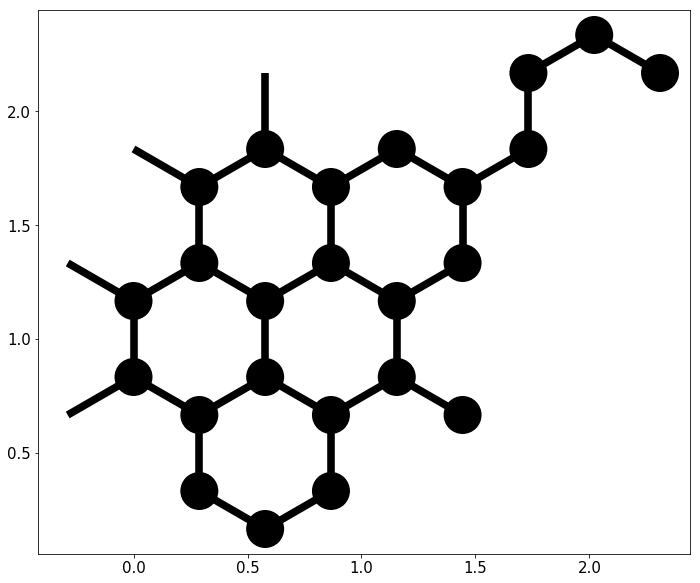

In [26]:
temp = make_zigzag_ribbon(N=10,L=9)
sites = [site for site in temp.sites()]

for site in sites: 
    if site.pos[0] > 1.5 and site.pos[1] < 1.5: 
        del temp[site]
    if site.pos[0] < 0.1 and site.pos[1] < 0.5: 
        del temp[site]
    if site.pos[0] > 1.0 and site.pos[1] < 0.5: 
        try:
            del temp[site]
        except: 
            continue
    if site.pos[0] < 1.5 and site.pos[1] > 2.0: 
        del temp[site]
    if site.pos[0] > 1.8 and site.pos[1] < 2.0: 
        try: 
            del temp[site]
        except: 
            continue 
    if site.pos[0] < 0.1 and site.pos[1] > 1.7: 
        try:
            del temp[site]
        except: 
            continue
#temp.eradicate_dangling()
    
#     if 1.5< site.pos[0] and site.pos[1] > 3.5: 
#         del temp[site]
#     if 0<=site.pos[0] < 0.1 and site.pos[1] < 0.5: 
#         del temp[site]
#     if site.pos[0] > 1 and site.pos[1] < 0.5: 
#         try:
#             del temp[site]
#         except: 
#             continue
#for site in sites: 
#    if 0 <= site.pos[0] < 0.8 and site.pos[1] < 0.5: 
#        del temp[site]
N2 = temp
N2 = finite_to_1D(N2,get_length(6),trans_sym_direction='x')
#kwant.plot(N3);
kwant.plot(N2,fig_size=(16,10));

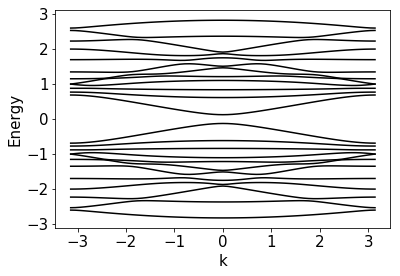


+----------------------------------------------------------------------+
|================                                                      |
|LINE CALCULATION                                                      |
|================                                                      |
|starting at 2019-06-24 12:49:53,313                                   |
|running Z2Pack version 2.1.1                                          |
|                                                                      |
|init_result: None                                                     |
|iterator:    range(8, 27, 2)                                          |
|line:        <function get_pol_custom.<<...>>.<lambda> at 0x11faa1510>|
|load:        False                                                    |
|load_quiet:  True                                                     |
|pos_tol:     0.01                                                     |
|save_file:   None                                

In [27]:
get_pol_custom(N2)

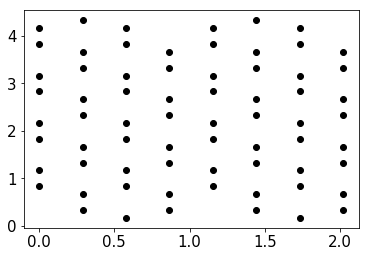

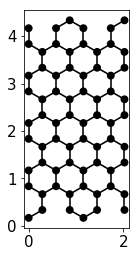

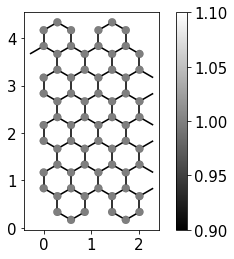

In [115]:
temp = make_zigzag_ribbon(N=18,L=8)
sites = [site for site in temp.sites()]

for site in sites: 
    if 0.5 < site.pos[0] < 0.7 and site.pos[1] < 0.5: 
         del temp[site]
    if 1.6 < site.pos[0] < 1.75 and site.pos[1] < 0.5: 
          del temp[site]
    if 0.2<site.pos[0] < 0.3 and site.pos[1] > 4: 
          del temp[site]
    if 1.4 < site.pos[0] < 1.7 and site.pos[1] > 4: 
          del temp[site]
#     if site.pos[0] > 1.0 and site.pos[1] < 0.5: 
#         try:
#             del temp[site]
#         except: 
#             continue
#     if site.pos[0] < 1.5 and site.pos[1] > 2.0: 
#         del temp[site]
#     if site.pos[0] > 1.8 and site.pos[1] < 2.0: 
#         try: 
#             del temp[site]
#         except: 
#             continue 
#     if site.pos[0] < 0.1 and site.pos[1] > 1.7: 
#         try:
#             del temp[site]
#         except: 
#             continue
pos = [site.pos for site in temp.sites()]
pos = translate(pos,get_length(2),18,8)
pos = np.array(pos)
plt.plot(pos[:,0],pos[:,1],'o')

kwant.plot(temp);

new_lattice = kwant.lattice.general([[get_length(8),0],[0,get_width(18)]],pos)
new_ribbon = kwant.Builder(kwant.TranslationalSymmetry(new_lattice.prim_vecs[0]))
#new_ribbon = kwant.Builder()
new_ribbon[new_lattice.shape((lambda pos: 0 <= pos[1] <= get_width(18)),(0,0))]=1
new_ribbon[new_lattice.neighbors()] = -1
fig = kwant.plot(new_ribbon,site_color=family_color,site_lw=0.01);

# #temp = finite_to_1D(temp,get_length(8),trans_sym_direction='x')
# #temp = translate(get_length(4))
# #temp = terminate_edges(temp)
# #kwant.plot(new_ribbon,fig_size=(16,10));

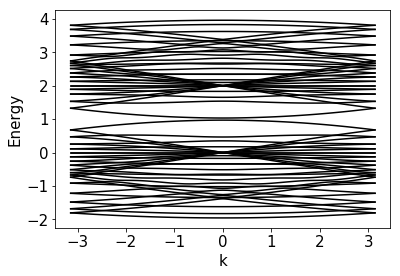


+----------------------------------------------------------------------+
|================                                                      |
|LINE CALCULATION                                                      |
|================                                                      |
|starting at 2019-06-24 14:04:37,337                                   |
|running Z2Pack version 2.1.1                                          |
|                                                                      |
|init_result: None                                                     |
|iterator:    range(8, 27, 2)                                          |
|line:        <function get_pol_custom.<<...>>.<lambda> at 0x12dd0e0d0>|
|load:        False                                                    |
|load_quiet:  True                                                     |
|pos_tol:     0.01                                                     |
|save_file:   None                                

In [116]:
get_pol_custom(new_ribbon)

In [85]:
def terminate_edges(syst): 
    sites = list(syst.sites())
    #print(sites)
    nsites = len(sites)
    pos = np.array([site.pos for site in sites])
    tags = [site.tag for site in sites]
    family = [site.family for site in sites]
    ymax = np.max(pos[:,1])
    ymin = np.min(pos[:,1])
    edge_index = []
    for i,p in enumerate(pos):
        print(p[1])
        if abs(p[1] - ymax) < 1.e-2 or abs(p[1]-ymin) < 1.e-2: 
            edge_index.append(i)
    nedges = len(edge_index)
    print(edge_index)
    edge_hoping_pairs = []
    for i in range(nedges): 
        site1 = sites[edge_index[i]]
        print(site1)
        #print(site1.pos)
        neigh_sites = syst.neighbors(site1)
        #print(neigh_sites)
        for site2 in neigh_sites: 
            #if abs(site2.pos[1] - ymax) < 1.0e-2  or abs(site2.pos[1]-ymin)< 1.0e-2:
            #print(syst.degree(site2))
            if syst.degree(site2) < 3: 
                hop_pair = [site1.pos,site2.pos]
                print(hop_pair)
                pair_seen = hop_pair in edge_hoping_pairs
                if not pair_seen:
                    syst[site1,site2] = -1 - 0.5
                    edge_hoping_pairs.append([site1.pos,site2.pos])
                    print(site1.pos)
                    print(site2.pos)
    #print(edge_hoping_pairs)
    #print(edge_index)           
    return syst

In [114]:
get_length(8)

2.309401076758503

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in double_scalars
  if __name__ == '__main__':


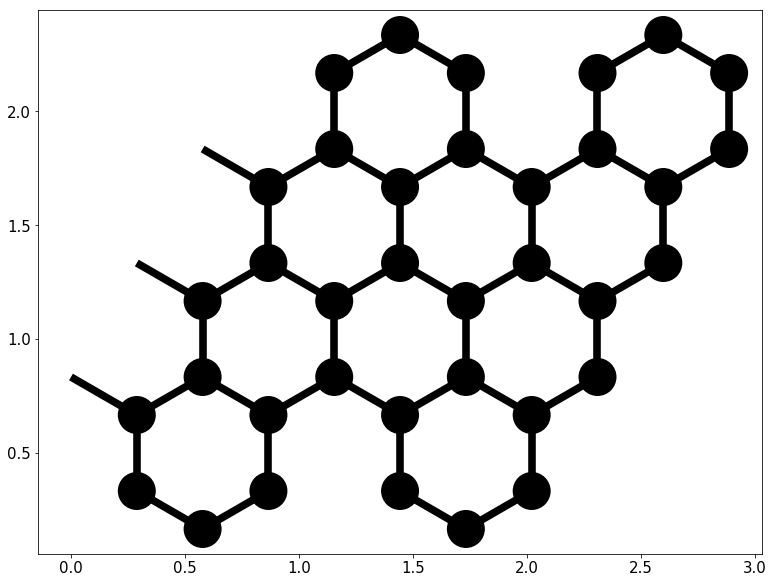

In [195]:
temp = make_zigzag_ribbon(N=10,L=13)
sites = [site for site in temp.sites()]
for site in sites: 
    if site.pos[1] > 0 and site.pos[0]==0:
        del temp[site]
    elif site.pos[1]/(site.pos[0]+get_length(2)/2) >= np.tan(np.pi/3):
        del temp[site]
    elif site.pos[0] >= get_length(7):
        if site.pos[1]/(site.pos[0]-get_length(7)) < np.tan(np.pi/3):
            del temp[site]
    if 1.0 <site.pos[0]< 1.2: 
        if site.pos[1] < 0.5:      
            del temp[site]
    if 1.8<site.pos[0]<2.2 or site.pos[0]>3.0: 
        if site.pos[1] > 2.2:
            del temp[site]
            
temp = finite_to_1D(temp,get_length(8),trans_sym_direction='x')
kwant.plot(temp,fig_size=(16,10));

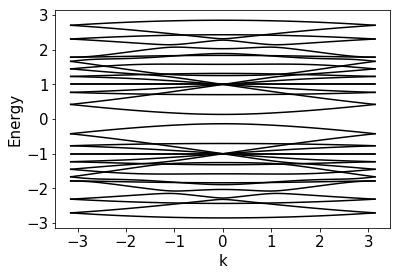


+----------------------------------------------------------------------+
|================                                                      |
|LINE CALCULATION                                                      |
|================                                                      |
|starting at 2019-06-24 14:55:28,078                                   |
|running Z2Pack version 2.1.1                                          |
|                                                                      |
|init_result: None                                                     |
|iterator:    range(8, 27, 2)                                          |
|line:        <function get_pol_custom.<<...>>.<lambda> at 0x12cb461e0>|
|load:        False                                                    |
|load_quiet:  True                                                     |
|pos_tol:     0.01                                                     |
|save_file:   None                                

In [196]:
get_pol_custom(temp)

In [ ]:
temp = make_zigzag_ribbon(N=10,L=13)
sites = [site for site in temp.sites()]
for site in sites: 
    if site.pos[1] > 0 and site.pos[0]==0:
        del temp[site]
    elif site.pos[1]/(site.pos[0]+get_length(2)/2) >= np.tan(np.pi/3):
        del temp[site]
    elif site.pos[0] >= get_length(7):
        if site.pos[1]/(site.pos[0]-get_length(7)) < np.tan(np.pi/3):
            del temp[site]
    if 1.0 <site.pos[0]< 1.2: 
        if site.pos[1] < 0.5:      
            del temp[site]
    if 1.8<site.pos[0]<2.2 or site.pos[0]>3.0: 
        if site.pos[1] > 2.2:
            del temp[site]
            
temp = finite_to_1D(temp,get_length(8),trans_sym_direction='x')
kwant.plot(temp,fig_size=(16,10));